# Metadata exploration

In this notebook we will explore the scope of the correspondence within the [Founders Online](https://www.founders.archives.gov/) dataset. This data used in this notebook is a preprocessed version. You can find the notebook where this preprocessing is done in the project repository on [Github](insert_link_here).

Primarily this notebook will focus on gathering data on letter counts as this is the easiest way to assess the scope of the dataset. 

In [1]:
#loading the relevant libraries
import pandas as pd
import datetime
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from heapq import nlargest
import math
import os

<ipython-input-1-27ca8e1476a7>:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
os.path.normpath(os.getcwd() + os.sep + os.pardir)
df = pd.read_csv("../data/archive_data/founders_online_data_exploration_data.csv", index_col=0)

In [3]:
#df.info()
#df.sample(3)

## Data exploration

To execute this exploration we first need to do some slight preprocessing. The dating columns are converted to a datetime format for easier querying, and by making an unnested version of the dataset for calculation purposes. We will also define a variable which will list all the founding fathers. This variable will be used along the whole notebook.

In [4]:
#changing datatypes and adding unnested version of the dataframe.
df[['date_from', 'date_to']] = df[['date_from', 'date_to']].astype('datetime64[ns]')
split_authors_recipients = df[['authors','recipients','id','date_from']].set_index(['id','date_from']).apply(lambda x: x.str.split('|')).explode('authors').explode('recipients').reset_index() 
split_authors_recipients['authors'] = split_authors_recipients['authors'].str.strip()
split_authors_recipients['recipients'] = split_authors_recipients['recipients'].str.strip()                                                                                                  

In [5]:
#saving a variable with list of founding fathers
founders = ['Washington, George', 'Adams, John', 'Jefferson, Thomas', 'Franklin, Benjamin',
              'Madison, James', 'Hamilton, Alexander','Jay, John']

### Letter counts

In this section we will generate some basic facts and descriptive statistics about the datset.

In [6]:
#querying amounts of correspondence and authorship
print('amount of correspondence:', len(df.index))
print('amount of authors:', len(split_authors_recipients['authors'].unique()))
print('amount of recipients:', len(split_authors_recipients['recipients'].unique()))
print('\navg letters authored per person:',(len(df.index))/(len(split_authors_recipients['authors'].unique())))
print('avg letters received per person:',(len(df.index))/(len(split_authors_recipients['recipients'].unique())))

amount of correspondence: 41878
amount of authors: 4278
amount of recipients: 2542

avg letters authored per person: 9.789153810191678
avg letters received per person: 16.474429583005506


In [7]:
#quantifying the presence of the founders in the corpus. 
print('amount of the corpus authored and received by at least one of the founding fathers:')
p = len(split_authors_recipients.loc[split_authors_recipients['authors'].isin(founders)])/(len(df.index))
print('authored:', f"{p:.2%}")
p = len(split_authors_recipients.loc[split_authors_recipients['recipients'].isin(founders)])/(len(df.index))
print('received:',f"{p:.2%}")

print('\namount of letters exchanged between the founding fathers:')
l_exchanged = len(split_authors_recipients.loc[split_authors_recipients['authors'].isin(founders) & split_authors_recipients['recipients'].isin(founders)])
print('amount exchanged:',l_exchanged)
p = l_exchanged/(len(df.index))
print('percentage total:', f"{p:.2%}")

amount of the corpus authored and received by at least one of the founding fathers:
authored: 45.78%
received: 61.65%

amount of letters exchanged between the founding fathers:
amount exchanged: 1317
percentage total: 3.14%


In [8]:
#calculating the top 10 most letters authored and received.
amount_authored = split_authors_recipients['authors'].value_counts()
amount_received = split_authors_recipients['recipients'].value_counts()
amount_auth_and_rec = pd.merge(amount_authored,amount_received, left_index=True,right_index=True).fillna(0)
amount_auth_and_rec['combined'] = (amount_auth_and_rec['authors'] + amount_auth_and_rec['recipients'])
amount_auth_and_rec = amount_auth_and_rec.rename(columns = {'authors':'authored'}).rename(columns = {'recipients':'received'})

print('top 10 most letters authored and received:')
amount_auth_and_rec.sort_values('combined', ascending=False).head(10)#.plot.barh()

top 10 most letters authored and received:


,authored,received,combined
"Washington, George",11199,12226,23425
"Franklin, Benjamin",2502,7342,9844
"Adams, John",2728,3446,6174
"Jefferson, Thomas",1537,1812,3349
"Lee, Arthur",590,1050,1640
"Heath, William",694,484,1178
American Commissioners,359,809,1168
"Dumas, Charles William Frederic",911,123,1034
"Hamilton, Alexander",647,353,1000
"Adams, Abigail",296,595,891


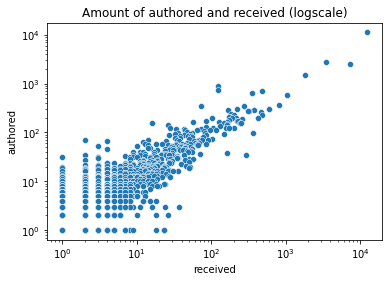

Correlation coefficient and p-value: 

(0.9463673038131465, 0.0)


In [9]:
#graphing amounts of letters authored as opposed to received.
ax = sns.scatterplot(data = amount_auth_and_rec, x='received', y='authored')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("Amount of authored and received (logscale)")
plt.show()

print('Correlation coefficient and p-value: \n')
print(pearsonr(amount_auth_and_rec['authored'],amount_auth_and_rec['received']))

### Count of lettercounts

In this section we explore the distribution of the lettercounts themselves. By doing this we can reveal how often certain lettercounts occur.

In [10]:
#calculating the percentage of actors that authored and received 1 to 10 letters
p = amount_authored.value_counts().sort_index().head(10).sum()/(len(split_authors_recipients['authors'].unique()))
print('percentage of actors that authored 1 to 10 letters:',f"{p:.2%}")
p = amount_received.value_counts().sort_index().head(10).sum()/(len(split_authors_recipients['recipients'].unique()))
print('percentage of actors that received 1 to 10 letters:',f"{p:.2%}")

percentage of actors that authored 1 to 10 letters: 90.14%
percentage of actors that received 1 to 10 letters: 87.57%


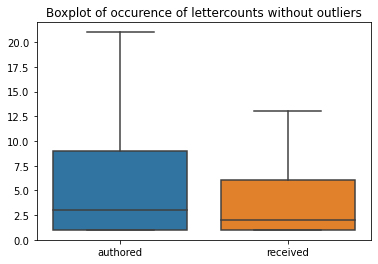

In [11]:
#plotting the distribution of lettercounts
sns.boxplot(data = amount_auth_and_rec[['authored','received']], showfliers = False)
plt.title("Boxplot of occurence of lettercounts without outliers")
plt.show()


### Counts over time

Here we query the dataset to show us the amount of letters send over time. We query the total amount send per month and the amount per founding father per month. 

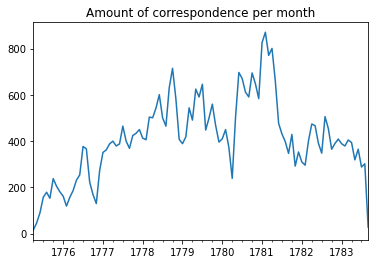

In [12]:
#graphing the amount of correspondence per month
ax = df['date_from'].dt.to_period('M').value_counts().sort_index(ascending=True).plot(title='Amount of correspondence per month')
plt.show()

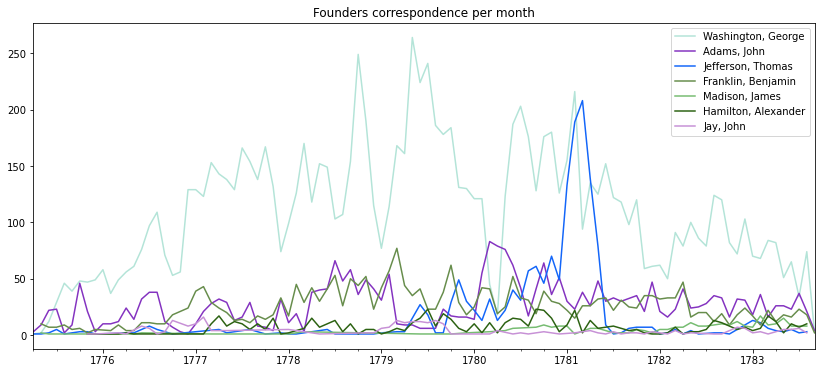

In [13]:
#querying and graphing the correspondence per founder per month.
for founder in founders:
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    
    dft = split_authors_recipients.loc[split_authors_recipients['authors'] == founder]
    ax = dft['date_from'].dt.to_period('M').value_counts().sort_index(ascending=True).plot(title='Founders correspondence per month', color=color, figsize=(14,6)) 
    ax.legend(founders)
